# Team Cobra Kai
### Objective: Utilize our repertoire of coding skills and knowledge of the game to analyze gaming data to create a "Super Squad" team of Champions

_Data Sources: Champion.gg & GamesofLegends eSports_


<img src="images/lol.png.jpeg" style="width: 9000px">



In [2]:
#Import dependencies
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import linregress
from matplotlib import pyplot as plt

#Color dependencies
from matplotlib import cm
from colorspacious import cspace_converter
import collections
from collections import OrderedDict
cmaps = OrderedDict()
cmaps['Perceptually Uniform Sequential'] = [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']


Bad key "text.kerning_factor" on line 4 in
/Users/laurenstein/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Preparing Data for Analysis

## Import csv files and convert to DataFrame

In [3]:
# ===== 2018-2020 Dataset from GamesofLegends to identify most popular Champions ===== #
champions_df = pd.read_csv("data/2018_2020_data/champion.csv", encoding="utf-8")

# ===== GG web site data - used for bulk of analysis ===== #
bronze_df = pd.read_csv("data/gg_datafiles/bronze.csv", encoding="utf-8")
gold_df = pd.read_csv("data/gg_datafiles/gold.csv", encoding="utf-8")
platinum_df = pd.read_csv("data/gg_datafiles/platinum.csv", encoding="utf-8")
platinumplus_df = pd.read_csv("data/gg_datafiles/platinumplus.csv", encoding="utf-8")
silver_df = pd.read_csv("data/gg_datafiles/silver.csv", encoding="utf-8")


In [4]:
#GG dataset is divided into 5 csv files for each League, combine data to increase sampling size
#Create a new column to specify the league for stacking the dataset
bronze_df["League"] = "Bronze"
gold_df["League"] = "Gold"
platinum_df["League"] = "Platinum"
platinumplus_df["League"] = "Platinum Plus"
silver_df["League"] = "Silver"

#Create stacked combined dataset
stack_df = pd.concat([bronze_df, 
                      gold_df, 
                      platinum_df, 
                      platinumplus_df,
                      silver_df], axis = 0)

## Explore the data

### Describe the dataset

#### Part 1: Identify most popular Champions


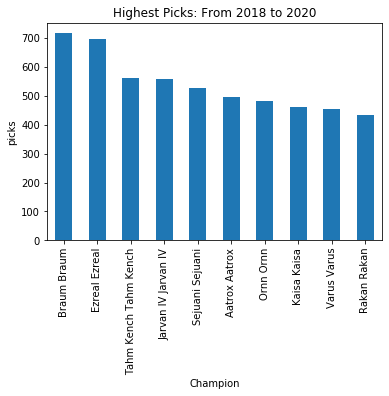

In [5]:
# Identify Most Popular Champions over the past 2 years
reduced_champions_df = champions_df.groupby(["Champion"]).mean()

#reduced_champions_df.head()
new = reduced_champions_df.sort_values(["picks"],ascending=False)["picks"]
healing_graph = new.head(10).plot(kind="bar")
healing_graph.set_ylabel("picks")
plt.title("Highest Picks: From 2018 to 2020")
plt.show()

__Quick Summary:__ Braum and Ezreal have the most picks over the past two years

#### Part 2: Clean the Chamion.gg dataset for remaining analysis

In [6]:
#Explore Columns in the dataset
stack_df.columns

Index(['Rank', 'Champion', 'Role', 'Win Percent', 'Play Percent', 'Ban Rate',
       'Playerbase Avg. Games', 'Kills', 'Deaths', 'Assists',
       'Largest Killing Spree', 'Damage Dealt', 'Damage Taken',
       'Total Healing', 'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
       'Gold Earned', 'Role Position', 'Position Change', 'League'],
      dtype='object')

In [7]:
#Get info on dataframe (datatypes, and null values)
stack_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 187
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   989 non-null    object 
 1   Champion               979 non-null    object 
 2   Role                   979 non-null    object 
 3   Win Percent            979 non-null    object 
 4   Play Percent           979 non-null    object 
 5   Ban Rate               979 non-null    object 
 6   Playerbase Avg. Games  898 non-null    float64
 7   Kills                  979 non-null    float64
 8   Deaths                 979 non-null    float64
 9   Assists                979 non-null    float64
 10  Largest Killing Spree  979 non-null    float64
 11  Damage Dealt           979 non-null    float64
 12  Damage Taken           979 non-null    float64
 13  Total Healing          979 non-null    float64
 14  Minions Killed         979 non-null    float64
 15  Enemy 

In [8]:
#Identify Null Values
df_null = stack_df[stack_df.isnull().any(axis=1)]

#Drop weird rows with no Champion listed & check non-null values
df2 = stack_df.dropna(subset = ['Champion'])
df2.info()

## === Notice that playerbase avg games still has less data (898) this column is not used for analysis === ##

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 185
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   979 non-null    object 
 1   Champion               979 non-null    object 
 2   Role                   979 non-null    object 
 3   Win Percent            979 non-null    object 
 4   Play Percent           979 non-null    object 
 5   Ban Rate               979 non-null    object 
 6   Playerbase Avg. Games  898 non-null    float64
 7   Kills                  979 non-null    float64
 8   Deaths                 979 non-null    float64
 9   Assists                979 non-null    float64
 10  Largest Killing Spree  979 non-null    float64
 11  Damage Dealt           979 non-null    float64
 12  Damage Taken           979 non-null    float64
 13  Total Healing          979 non-null    float64
 14  Minions Killed         979 non-null    float64
 15  Enemy 

In [9]:
#Percentage values showing up as OBJECTS, 
champ_df = df2.groupby(["Champion"]).mean()
champ_df.head()

,Playerbase Avg. Games,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
Champion,,,,,,,,,,,,,,
Aatrox,8.174286,4.644286,4.957143,4.828571,6.000000,15734.857143,26087.000000,10089.857143,141.042857,2.104286,3.094286,9579.00,31.714286,2.714286
Ahri,8.608333,6.106667,5.121667,7.061667,6.666667,18547.666667,17217.333333,3221.166667,142.950000,0.858333,2.855000,10288.50,20.500000,5.166667
Akali,12.318333,6.916667,5.678333,4.551667,7.500000,17378.416667,22477.916667,6146.250000,142.008333,1.011667,1.869167,10186.75,40.000000,2.250000
Alistar,3.300000,1.910000,5.650000,12.508000,3.800000,7564.200000,20848.200000,8914.200000,30.640000,0.076000,0.108000,7387.20,26.600000,4.200000
Amumu,2.844000,4.554000,5.704000,9.666000,6.800000,13318.600000,26994.400000,7621.200000,32.500000,6.590000,80.366000,10134.60,28.400000,1.600000


__IMPORTANT: There are NO stats for three important metrics (Win Percent, Play Percent, Ban Rate)__

Requires cleaning/manipulation of the dataset

In [10]:
#Create a function to convert percent to float to enable calculations
def convert_percent(val):
    """
    Convert the percentage string to an actual floating point percent
    - Remove %
    - Divide by 100 to make decimal
    """
    new_val = val.replace('%', '')
    return float(new_val) / 100

# Created a new column that applies the function to convert percentage to float
# See below for alternative method that did NOT work, I am not sure why though

df2['win_percent'] = df2["Win Percent"].apply(convert_percent)
df2['ban_rate'] = df2["Ban Rate"].apply(convert_percent)
df2['play_percent'] = df2["Play Percent"].apply(convert_percent)

# Drop extra columns
df2.drop(columns=['Win Percent', 'Play Percent', 'Ban Rate'])

#Reorder columns and remove unnecessary columns
df2.columns
df2 = df2.reindex(columns = ['Rank', 'Champion', 'Role', 'League',
       'win_percent', 'ban_rate', 'play_percent',
       'Kills', 'Deaths', 'Assists',
       'Largest Killing Spree', 'Damage Dealt', 'Damage Taken',
       'Total Healing', 'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
       'Gold Earned', 'Role Position', 'Position Change'])
df2.head()

ipykernel_launcher:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Rank,Champion,Role,League,win_percent,ban_rate,play_percent,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
0,1,Aatrox,Top,Bronze,0.4690,0.0042,0.0206,5.49,5.90,5.96,7.0,18687.0,31430.0,12450.0,146.8,2.52,3.66,10685.0,35.0,1.0
1,2,Ahri,Middle,Bronze,0.5184,0.0030,0.0333,6.82,5.69,7.73,7.0,20593.0,18989.0,3499.0,140.2,0.85,2.83,10769.0,20.0,3.0
2,3,Akali,Middle,Bronze,0.4379,0.0077,0.0349,8.45,6.61,5.48,10.0,19250.0,25051.0,6740.0,133.9,1.16,2.28,10933.0,40.0,2.0
3,4,Akali,Top,Bronze,0.4667,0.0077,0.0127,7.21,6.06,4.82,7.0,19055.0,24429.0,6704.0,145.3,1.18,1.71,10718.0,40.0,0.0
4,5,Alistar,Support,Bronze,0.5176,0.0007,0.0243,2.02,5.84,12.80,4.0,7948.0,21527.0,9162.0,30.8,0.10,0.13,7501.0,22.0,6.0


In [11]:
#Explore Unique Values in the Dataset
ind_list = []
unique_count = []
for col in df2.columns:
    ind_list.append(col)
    unique_count.append(len(df2[col].unique()))
final_series = pd.DataFrame({'Feature':ind_list,'Unique values':unique_count}).sort_values(by='Unique values',ascending=True).reset_index(drop=True).style.bar()
final_series

,Feature,Unique values
0,Role,5
1,League,5
2,Largest Killing Spree,10
3,Position Change,21
4,Role Position,71
5,Champion,148
6,ban_rate,215
7,Rank,232
8,Deaths,287
9,play_percent,470


__Quick Summary:__ Data consists of 5 leagues and 5 roles

In [12]:
##Check whether or not all leagues have the same number of champions
#Number of unique champions per league
league_df_champ = df2.groupby(["League"]).nunique()["Champion"]
league_df_champ

League
Bronze           148
Gold             140
Platinum         146
Platinum Plus    148
Silver           146
Name: Champion, dtype: int64

In [13]:
#Number of Roles
league_df_role = df2.groupby(["League"]).nunique()["Role"]
league_df_role

League
Bronze           5
Gold             5
Platinum         5
Platinum Plus    5
Silver           5
Name: Role, dtype: int64

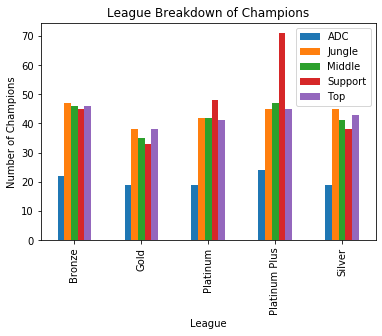

In [14]:
#Create a graph that shows the number of Champions per Role with League as the X axis
role_chart = df2.groupby(["League", "Role"]).count()["Rank"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Number of Champions")
plt.title("League Breakdown of Champions")
plt.legend(loc="best")
plt.show()

# Analyze the Data


1. Based on our knowledge of the game we were able to identify the key traits/metrics for each role
2. Create new dataframe for each role then calculate mean for each metric each champion then sort
3. Graph the top 10 Champions per metric

__NOTE: Only analyzed 3/5 roles__

## Support Role Analysis

* High total healing

* High damage taken

* High minion kills

* Low death

* High assist

In [15]:
#Create new data frame with just support role
support = df2.loc[df2["Role"] == "Support"][["Rank", "Champion", "League", 'Total Healing', 'Damage Taken', 'Minions Killed', "Deaths", 'Assists']]

#groupby Champion - merges League
champ_support = support.groupby("Champion").mean()

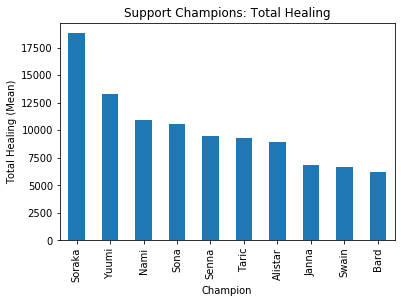

In [16]:
#Bar chart for healing
healing = champ_support.sort_values(["Total Healing"],ascending=False)["Total Healing"]
healing_graph = healing.head(10).plot(kind="bar")
healing_graph.set_ylabel("Total Healing (Mean)")
plt.title("Support Champions: Total Healing")
plt.show()

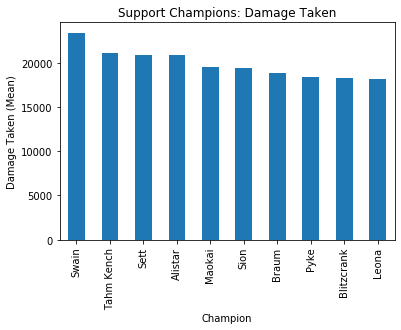

In [17]:
#Bar chart for Damage Taken
damage = champ_support.sort_values(["Damage Taken"],ascending=False)["Damage Taken"]
damage_graph = damage.head(10).plot(kind="bar")
damage_graph.set_ylabel("Damage Taken (Mean)")
plt.title("Support Champions: Damage Taken")
plt.show()

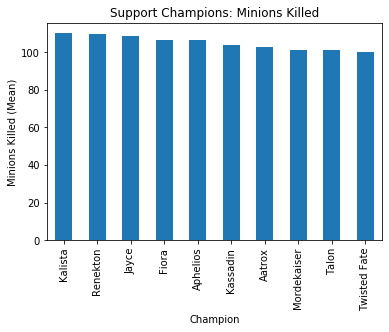

In [18]:
#Bar chart for High Minions Taken
minions = champ_support.sort_values(["Minions Killed"],ascending=False)["Minions Killed"]
minion_graph = minions.head(10).plot(kind="bar")
minion_graph.set_ylabel("Minions Killed (Mean)")
plt.title("Support Champions: Minions Killed")
plt.show()

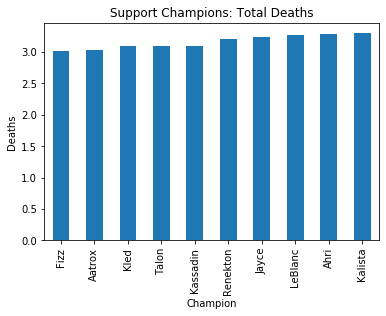

In [19]:
#Bar chart for Deaths Taken
death = champ_support.sort_values(["Deaths"], ascending = True)["Deaths"]
death_graph = death.head(10).plot(kind="bar")
death_graph.set_ylabel("Deaths")
plt.title("Support Champions: Total Deaths")
plt.show()

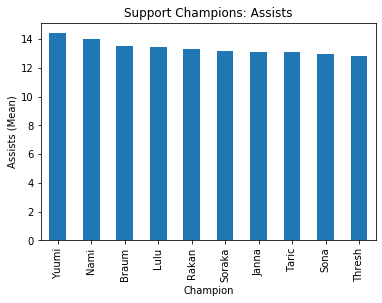

In [20]:
#Bar chart for Assist
assist = champ_support.sort_values(["Assists"],ascending=False)["Assists"]
minion_graph = assist.head(10).plot(kind="bar")
minion_graph.set_ylabel("Assists (Mean)")
plt.title("Support Champions: Assists")
plt.show()

#  Mid Role Analysis

* High kills
* Low deaths
* High assist
* High minions kills

In [21]:
Jim_group = stack_df.loc[stack_df.Role == "Middle"].groupby("Champion")[["Kills","Deaths","Assists","Minions Killed"]].mean()
Jim_group.head()

,Kills,Deaths,Assists,Minions Killed
Champion,,,,
Ahri,6.6500,5.490,7.6720,153.360
Akali,8.1620,6.326,5.3820,144.940
Anivia,5.8300,4.665,7.5025,170.500
Annie,7.6000,6.200,7.6060,150.940
Aurelion Sol,5.7125,5.590,8.6950,145.425


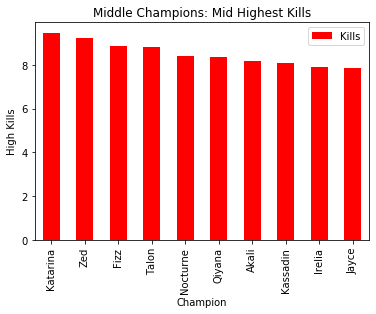

In [22]:
kills_df = Jim_group.sort_values("Kills",ascending=False)[["Kills"]].head(10)
kills_graph = kills_df.plot(kind="bar", color="red")
kills_graph.set_ylabel("High Kills")

plt.title("Middle Champions: Mid Highest Kills")
#plt.grid()
plt.show()

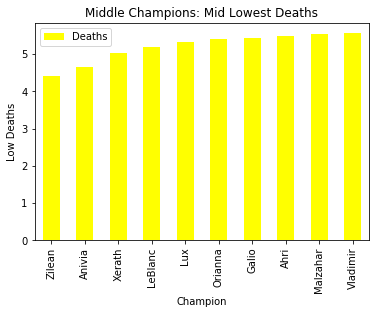

In [23]:
low_deaths_df = Jim_group.sort_values("Deaths")[["Deaths"]].head(10)
low_deaths_graph = low_deaths_df.plot(kind="bar",color="yellow")
low_deaths_graph.set_ylabel("Low Deaths")
plt.title("Middle Champions: Mid Lowest Deaths")
plt.show()

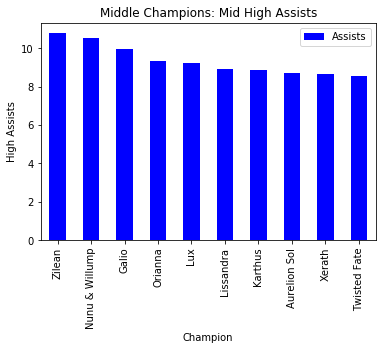

In [24]:
high_assists_df = Jim_group.sort_values("Assists",ascending=False)[["Assists"]].head(10)
high_assists_graph = high_assists_df.plot(kind="bar",color="blue")
high_assists_graph.set_ylabel("High Assists")
plt.title("Middle Champions: Mid High Assists")
plt.show()

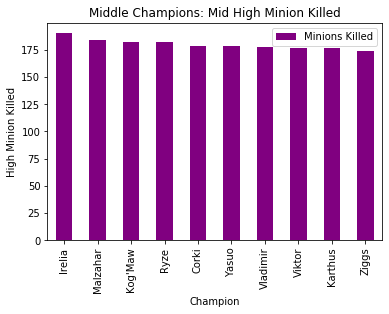

In [25]:
high_minion_killed_df = Jim_group.sort_values("Minions Killed",ascending=False)[["Minions Killed"]].head(10)
high_minion_killed_graph = high_minion_killed_df.plot(kind="bar", color="purple",linewidth=10)
high_minion_killed_graph.set_ylabel("High Minion Killed")
plt.title("Middle Champions: Mid High Minion Killed")
plt.show()

# ADC (Attack Damage Carry)

1) High Gold Earned

2) High Damage Taken

3) High Damage Dealt

Note: ADC-is an archaic term used to refer to a champion that deals strong, continuous damage with their basic attacks and scales with attack-related stats - i.e. attack damage, critical strike chance and attack speed.

In [26]:
#Use Loc command to look for specific Role and Role's cotribution to team
stack_df.loc[stack_df.Role == "ADC"][["Gold Earned","Damage Taken","Damage Dealt"]]

#Calculate mean on privious output
champ_grp = stack_df.loc[stack_df.Role == "ADC"].groupby("Champion")[["Gold Earned","Damage Taken","Damage Dealt"]].mean()

### Analyze metrics for ADC across Leagues

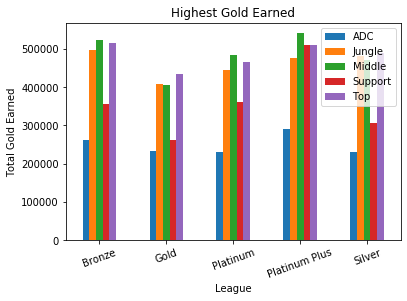

In [27]:
role_chart = stack_df.groupby(["League", "Role"]).sum()["Gold Earned"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Total Gold Earned")
plt.title("Highest Gold Earned")
plt.xticks(rotation=20)
plt.legend(loc="best")
plt.show()

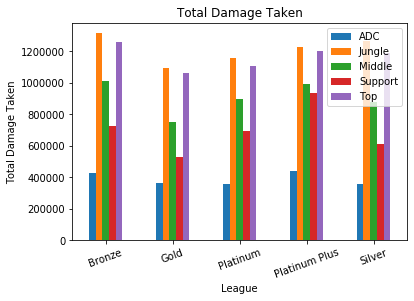

In [28]:
#Comparison of Total Damage Taken by League
role_chart = stack_df.groupby(["League", "Role"]).sum()["Damage Taken"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Total Damage Taken")
plt.title("Total Damage Taken")
plt.xticks(rotation=20)
plt.legend(loc="best")
plt.show()

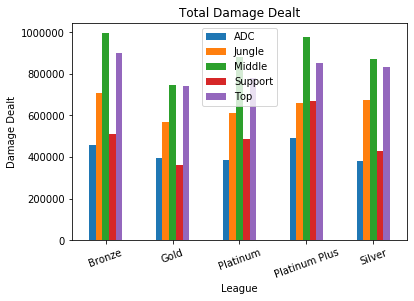

In [29]:
role_chart = stack_df.groupby(["League", "Role"]).sum()["Damage Dealt"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Damage Dealt")
plt.title("Total Damage Dealt")
plt.xticks(rotation=20)
plt.legend(loc="best")
plt.show()

### Top 10 breakdown for ADC Champions

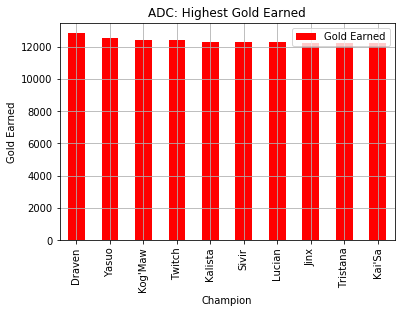

In [30]:
#Highest Gold Earned Champion in a Game
gold_df = champ_grp.sort_values("Gold Earned",ascending=False)[["Gold Earned"]].head(10)
gold_df = gold_df.plot(kind = "bar",color="red",linewidth=5)
gold_df.set_ylabel("Gold Earned")
plt.title("ADC: Highest Gold Earned")
plt.grid()
plt.show()

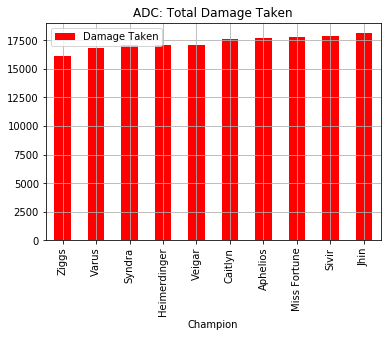

In [31]:
#Highest Damage Taken in a Game
damage_taken = champ_grp.sort_values("Damage Taken",ascending=True)[["Damage Taken"]].head(10)
damage_taken_df = damage_taken.plot(kind = "bar", color="red",linewidth=5)
gold_df.set_ylabel("Damage Taken")
plt.title("ADC: Total Damage Taken")
plt.grid()
plt.show()

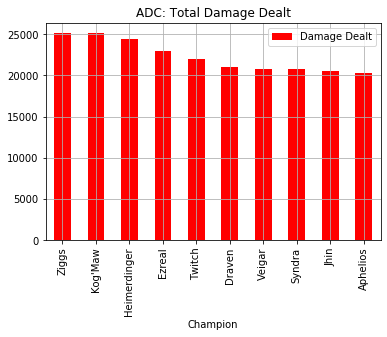

In [32]:
#Highest Damage dealt in a Game
damage_dealt = champ_grp.sort_values("Damage Dealt",ascending=False)[["Damage Dealt"]].head(10)
damage_dealt_df = damage_dealt.plot(kind = "bar", color="red",linewidth=5)
gold_df.set_ylabel("Damage Dealt")
plt.title("ADC: Total Damage Dealt")
plt.grid()
plt.show()

# Correlation Analysis

## Pairplot analysis of all metrics to visualize correlations and distribution of the data

In [33]:
#What we most care about is the win_percent correlation analysis (first column)
#Colors refer to different Champion Roles
sns.pairplot(df2, hue="Role")

KeyboardInterrupt: 

## Pairplot analysis of a few metrics for presentation purposes

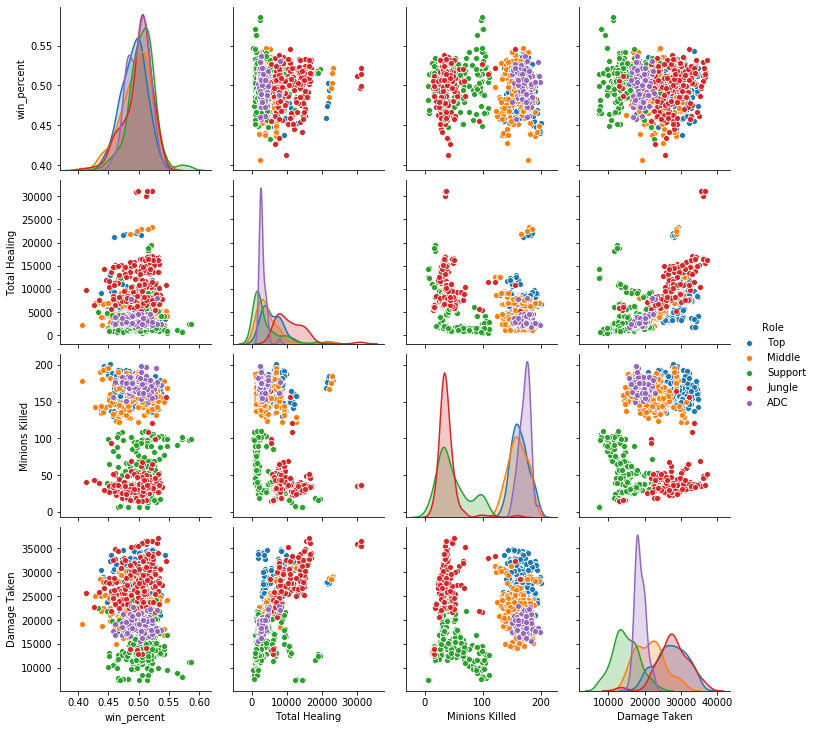

In [34]:
#Subset of Data for Presentation
sub1_df2 = df2[["win_percent", "Role", "Total Healing", "Minions Killed", "Damage Taken"]]
sns_plot = sns.pairplot(sub1_df2, hue="Role")
sns_plot.savefig("images/pairplot.png")


In [65]:
# Correlation analysis Numerical
# Continued below with heatmaps for a visual representation
df2.corr().sort_values("win_percent", ascending=False)

,win_percent,ban_rate,play_percent,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
win_percent,1.000000,-0.005536,0.074383,-0.163482,-0.313124,0.167246,-0.149775,-0.130749,-0.132912,-0.042907,-0.137264,-0.010035,0.011130,-0.167595,-0.429808,0.117937
Assists,0.167246,-0.079953,0.260874,-0.539509,-0.034318,1.000000,-0.379033,-0.386024,-0.229634,0.080424,-0.493803,-0.194864,0.000891,-0.382188,-0.158185,-0.041355
Position Change,0.117937,-0.155120,-0.144379,-0.100648,-0.129240,-0.041355,-0.125738,-0.068169,-0.028556,0.002631,-0.032447,0.001329,0.007344,-0.109378,0.097975,1.000000
play_percent,0.074383,0.459707,1.000000,0.044148,0.068151,0.260874,0.223049,-0.079294,-0.037693,0.069884,-0.127001,0.066001,0.086804,0.066669,-0.564827,-0.144379
Team Jungle CS,0.011130,-0.008432,0.086804,0.198875,-0.003833,0.000891,0.213247,-0.141207,0.467038,0.578294,-0.546457,0.915114,1.000000,0.138849,-0.020586,0.007344
ban_rate,-0.005536,1.000000,0.459707,0.116228,0.116353,-0.079953,0.155158,-0.030767,0.052348,0.063311,-0.009039,0.025211,-0.008432,0.046162,-0.434719,-0.155120
Enemy Jungle CS,-0.010035,0.025211,0.066001,0.360650,0.114639,-0.194864,0.331616,0.022853,0.554940,0.550567,-0.331294,1.000000,0.915114,0.340177,-0.085563,0.001329
Total Healing,-0.042907,0.063311,0.069884,0.060557,0.013760,0.080424,0.052433,-0.111251,0.604629,1.000000,-0.322803,0.550567,0.578294,0.106868,-0.121171,0.002631
Damage Dealt,-0.130749,-0.030767,-0.079294,0.751742,0.563903,-0.386024,0.593013,1.000000,0.279104,-0.111251,0.741225,0.022853,-0.141207,0.837401,-0.288031,-0.068169
Damage Taken,-0.132912,0.052348,-0.037693,0.409520,0.353315,-0.229634,0.314612,0.279104,1.000000,0.604629,0.094642,0.554940,0.467038,0.531374,-0.144724,-0.028556


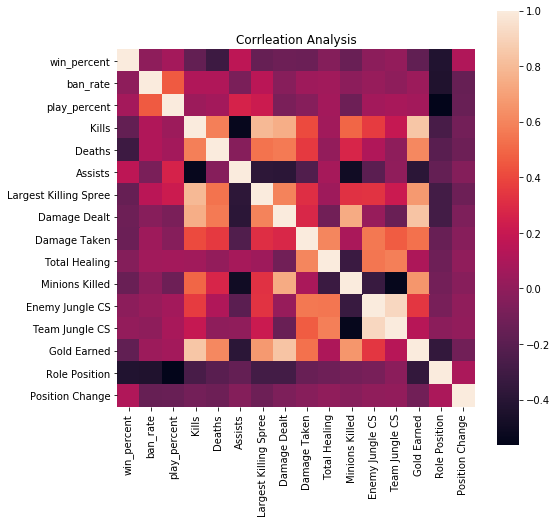

In [35]:
#Correlation Analysis for Complete Data Set
plt.figure(figsize=(8,8))
sns.heatmap(df2.corr(),annot=False,square=True)
plt.title("Corrleation Analysis")
plt.savefig('images/heatmap.png')

#### Champions
* moderate __negative__ correlation between Deaths and Win Rate (as expected) but also Role Position.

## Analysis of each Champion Role
### Support Champion

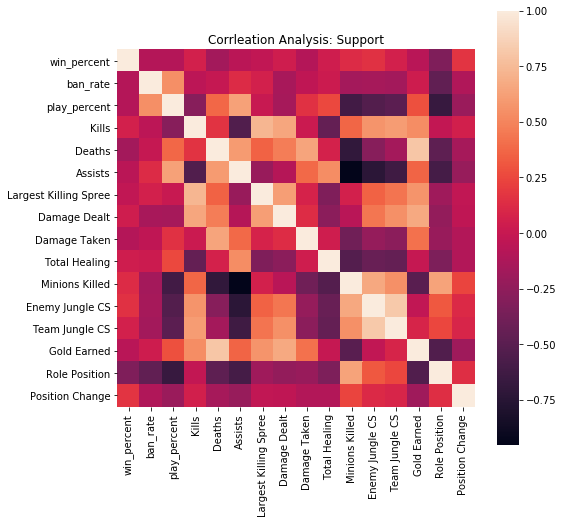

In [69]:
support = df2.loc[df2["Role"] == "Support"]
plt.figure(figsize=(8,8))
sns.heatmap(support.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Support")
plt.show()

#### Support Champion:
* __weak negative__ correlation between Role Posiion and win_rate for Support Champions
* No other measurements stood out as strongly correlative

### Jungle Champion

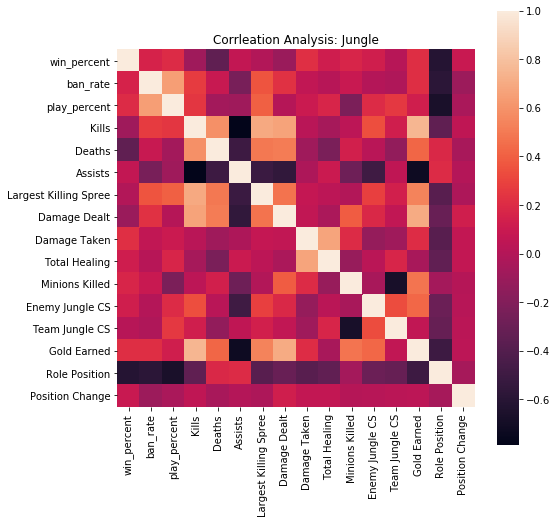

In [70]:
jungle = df2.loc[df2["Role"] == "Jungle"]
plt.figure(figsize=(8,8))
sns.heatmap(jungle.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Jungle")
plt.show()

#### Jungle Champion:
* __weak positive__ correlation between damage taken, gold earned, percent played with win percent
* __strong negative__ correlation with Role Position and win percent

### Middle Champion

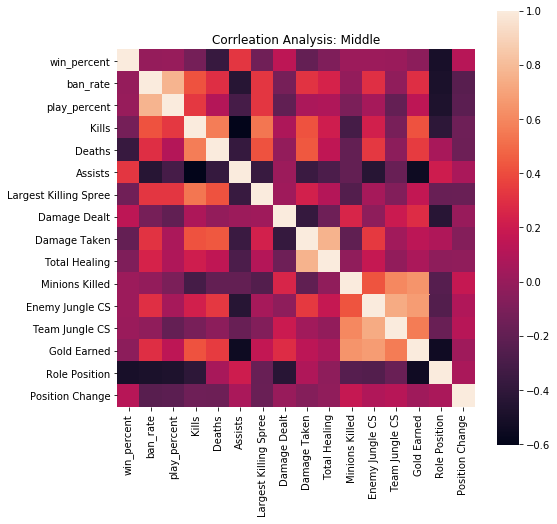

In [71]:
middle = df2.loc[df2["Role"] == "Middle"]
plt.figure(figsize=(8,8))
sns.heatmap(middle.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Middle")
plt.show()

#### Middle Champion:
* __mild posistive__ correlation between Assists and Win Percent
* __mild negative__ correaltion between Role Position and Win Percent 

### Top Champion

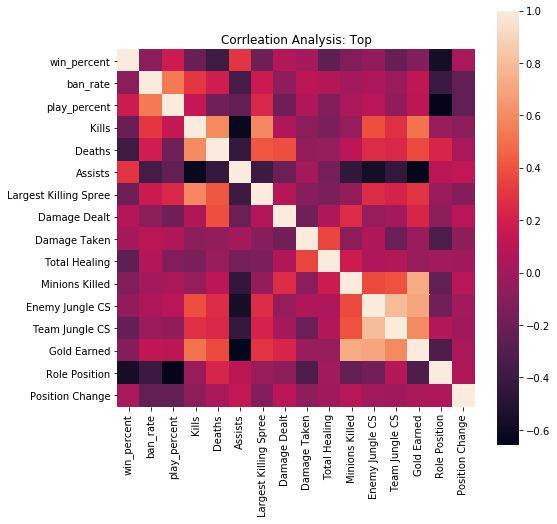

In [116]:
top = df2.loc[df2["Role"] == "Top"]
plt.figure(figsize=(8,8))
sns.heatmap(top.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Top")
plt.show()

#### Top Champion:
* __mild posistive__ correlation between Assists and win percent
* __mild negative__ correaltion between kills, total healing and win percent
* __strong negative__ correlation between role position and win percent

### ADC Champion

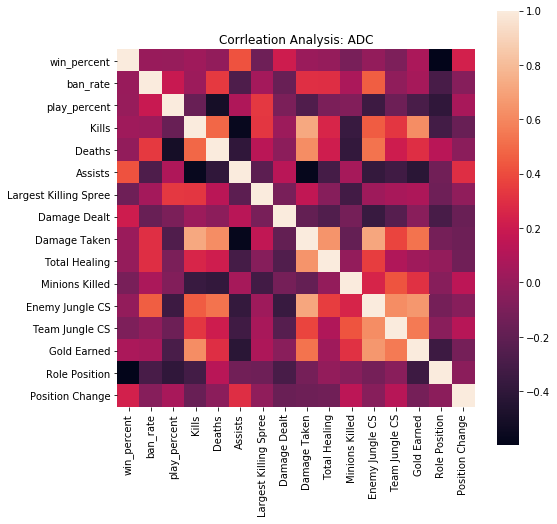

In [117]:
ADC = df2.loc[df2["Role"] == "ADC"]
plt.figure(figsize=(8,8))
sns.heatmap(ADC.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: ADC")
plt.show()

#### ADC Champion:
* __moderate posistive__ correlation between Assists and win percent
* __mild positive__ correaltion between psition change and damage dealt with win percent
* __strong negative__ correlation between role position and win percent

### Matplotlib Scatterplot with Line Regression

The r-squared is: 0.09804673350597999


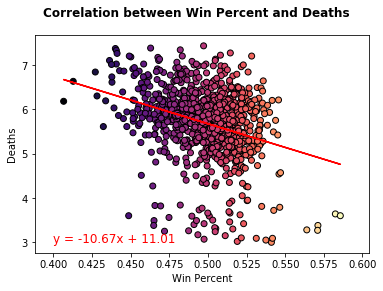

In [39]:
x_win = df2["win_percent"]
y_deaths = df2["Deaths"]

#slope calculations
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_win, y_deaths)
regress_values = x_win * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.ylabel('Deaths')
plt.xlabel('Win Percent')


t=x_win
plt.scatter(x_win, y_deaths, marker="o", edgecolor = "black", c=t, cmap='magma')
plt.suptitle("Correlation between Win Percent and Deaths", fontsize=12, fontweight = "bold")
plt.plot(x_win, regress_values, "r-")
plt.annotate(line_eq,(0.4,3),fontsize=12, color = "red")


print(f"The r-squared is: {rvalue**2}")

plt.savefig("images/regress.png")

## Finding the SUPER SQUAD!!!!
#### Creating an algorithm to find the most viable champion for each role 

In [ ]:
df2.columns
df2 = df2.reindex(columns = ['Rank', 'Champion', 'Role', 'League',
       'win_percent', 'ban_rate', 'play_percent',
       'Playerbase Avg. Games', 'Kills', 'Deaths', 'Assists',
       'Largest Killing Spree', 'Damage Dealt', 'Damage Taken',
       'Total Healing', 'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
       'Gold Earned', 'Role Position', 'Position Change'])
df2.head()

In [ ]:
# Creating Jungle dataframe
jungle = df2.loc[df2["Role"] == "Jungle"][["Rank", "Champion", "League", 'Minions Killed', "Enemy Jungle CS", 'Team Jungle CS', "Role Position", "Assists"]]
jungle.head()

In [ ]:
# Running calc to get most viable jungler
top_score = 0
top_name = ''
current_score = 0
for index, row in jungle.iterrows(): 
    current_score = (row['Minions Killed'] + row['Enemy Jungle CS'] 
                     + row['Team Jungle CS'] + row['Role Position'] 
                     + row['Assists'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Jungler with a score of {int(top_score)}')


In [ ]:
# Creating Support dataframe
support = df2.loc[df2["Role"] == "Support"][["Rank", "Champion", "League", 'Minions Killed', "Total Healing", 'Damage Taken', "Deaths", "Assists"]]
support.head()

In [ ]:
# Running calc to find the most viable Support
top_score = 0
top_name = ''
current_score = 0
for index, row in support.iterrows(): 
    current_score = (row['Minions Killed'] - row['Deaths'] 
                     + row['Total Healing'] + row['Damage Taken'] 
                     + row['Assists'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Support with a score of {int(top_score)}')

In [ ]:
# Creating Top dataframe
top = df2.loc[df2["Role"] == "Top"][["Rank", "Champion", "League", 'Kills', 'Minions Killed', "Largest Killing Spree", 'Damage Dealt', "Deaths", "Assists"]]
top.head()

In [ ]:
# Running calc to find most viable Top
top_score = 0
top_name = ''
current_score = 0
for index, row in top.iterrows(): 
    current_score = (row['Minions Killed'] - row['Deaths'] 
                     + row['Kills'] + row['Largest Killing Spree'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Top with a score of {int(top_score)}')

In [ ]:
# Creating Mid dataframe
mid = df2.loc[df2["Role"] == "Middle"][["Rank", "Champion", "League", 'Kills', 'Minions Killed', "Deaths", "Assists", 'Damage Dealt']]
mid.head()

In [ ]:
# Running calc to find most viable mid
top_score = 0
top_name = ''
current_score = 0
for index, row in mid.iterrows(): 
    current_score = (row['Minions Killed'] - row['Deaths'] + row['Kills'] + row['Assists'] + row['Damage Dealt'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Mid with a score of {int(top_score)}')

In [ ]:
#creating ADC dataframe
ADC = df2.loc[df2["Role"] == "ADC"][["Rank", "Champion", "League", 'Kills', "Largest Killing Spree", 'Damage Dealt', "Assists"]]
ADC.head()

In [ ]:
#Running calc to find the most viable ADC
top_score = 0
top_name = ''
current_score = 0
for index, row in ADC.iterrows(): 
    current_score = (row['Largest Killing Spree'] + row['Damage Dealt'] + row['Kills'] + row['Assists'] + row['Damage Dealt'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable ADC with a score of {int(top_score)}')